# Profiling results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from functools import wraps
from time import time
import scipy.sparse

In [2]:
def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print("Elapsed time: {}".format(end-start))
        return result
    return wrapper

# Euclidean distance between two sets

In [3]:
np.random.seed(5566)
N = 1000
M = 100
D = 50

In [4]:
A = np.random.uniform(low=-1, high=1, size=(N, D))
B = np.random.uniform(low=-1, high=1, size=(M, D))

In [5]:
# def getDistanceLoop(A, B):
#     N = A.shape[0]
#     M = A.shape[0]
    
#     C = np.zeros((N, M))
    
#     for n in range(N):
#         for m in range(M):
#             C[n, m] = np.sqrt(np.sum((A[n, :] - B[m, :])**2))
            
#     return C

# def getDistanceVec(A, B):
#     N = A.shape[0]
#     M = B.shape[0]
#     D = A.shape[1]
    
#     return np.sqrt(A**2@np.ones([D, M]) + np.ones([N, D])@B.T**2 - 2*A@B.T)

In [6]:
@timing
def getDistanceLoop(A, B):
    N = A.shape[0]
    M = B.shape[0]
    
    C = np.zeros((N, M))
    
    for n in range(N):
        for m in range(M):
            C[n, m] = np.sqrt(np.sum((A[n, :] - B[m, :])**2))
            
    return C

In [7]:
@timing
def getDistanceVec(A, B):
    N = A.shape[0]
    M = B.shape[0]
    D = A.shape[1]
    
    return np.sqrt(A**2@np.ones([D, M]) + np.ones([N, D])@B.T**2 - 2*A@B.T)


In [8]:
C_loop = getDistanceLoop(A, B)
C_vec = getDistanceVec(A,B)

Elapsed time: 1.3095738887786865
Elapsed time: 0.006134033203125


In [9]:
np.allclose(C_loop, C_vec)

True

# Cluster centers

In [10]:
np.random.seed(5566)
N = 1000
D = 50
K = 100
cluster_assign = np.random.choice(K, N)
I = cluster_assign
J = np.arange(N)
V = np.ones(N)
E = scipy.sparse.coo_matrix((V,(I,J)),shape=(K, N)).toarray()

X = np.random.uniform(low=-1, high=1, size=(N, D))

In [11]:
# def getCenters1(X, E):
#     K = E.shape[0]
#     D = X.shape[1]
#     C = np.zeros([K, D])
    
#     for k in range(K):
#         member_index = np.where(E[k, :]==1)[0]
#         C[k, :] = np.mean(X[member_index, :], axis=0)
#     return C

# def getCenters2(X, E):
#     return E@X/np.sum(E, axis=1, keepdims=True)

In [12]:
@timing
def getCenters1(X, E):
    K = E.shape[0]
    D = X.shape[1]
    C = np.zeros([K, D])
    
    for k in range(K):
        member_index = np.where(E[k, :]==1)[0]
        C[k, :] = np.mean(X[member_index, :], axis=0)
    return C

In [13]:
@timing
def getCenters2(X, E):
    return E@X/np.sum(E, axis=1, keepdims=True)

In [14]:
C_1 = getCenters1(X, E)
C_2 = getCenters2(X, E)
np.allclose(C_1, C_2)

Elapsed time: 0.006078004837036133
Elapsed time: 0.0009951591491699219


True

# K means

In [15]:
N = 1000
D = 50
K = 100
X = np.random.uniform(low=-1, high=1, size=(N, D))

def kmeans(X, K):
    # X: data N x D
    # K: cluster number, scalar
    J = np.arange(N)
    V = np.ones(N)

    cluster_assign = np.random.choice(K, N)
    prev_assign = np.zeros(cluster_assign.shape, dtype=np.int32)

    while any(cluster_assign != prev_assign):
        prev_assign = cluster_assign
        E = scipy.sparse.coo_matrix((V,(prev_assign,J)),shape=(K, N)).toarray() # indicator matrix
        centers = E@X/np.sum(E, axis=1, keepdims=True) # K x D
        dist = centers**2@np.ones([D, N]) - 2*centers@X.T # KxN
        cluster_assign = np.argmin(dist, axis=0)
    return cluster_assign

# loggausspdf

In [16]:
from scipy.stats import multivariate_normal

In [17]:
N = 1000
D = 10

X = np.random.uniform(low=-1, high=1, size=(N, D))

mu = np.mean(X, axis=0)
Sigma = np.cov(X.T)

In [18]:
def loggausspdf(X, mu, Sigma):
    D = X.shape[1]
    x_tilde = X-mu
    U = np.linalg.cholesky(Sigma)
    v = np.linalg.solve(U.T, x_tilde.T)
    Q = np.sum(v**2, axis=0)
    constant = D*np.log(2*np.pi)+2*np.sum(np.log(np.diag(U)))

    return -(Q+constant)/2

In [19]:
ll = loggausspdf(X, mu, Sigma)
ll2 =  multivariate_normal.logpdf(X, mean=mu, cov=Sigma)

# GMM

In [20]:
N = 50
D = 2
K = 3
np.random.seed(5566)
mu = np.random.uniform(low=-2, high=2, size=(K, D)) # row major
Sigma = np.zeros((K, D, D))

Sigma[0, :, :] = np.array([[0.3, 0], [0, 0.3]])
Sigma[1, :, :] = np.array([[0.01, 0], [0, 0.01]])
Sigma[2, :, :] = np.array([[0.2, 0.05], [0.05, 0.2]])
# for k in range(K):
#     temp = np.random.uniform(high=0.02, size=2)
#     Sigma[k, :, :] = np.array([[temp[0], 0], [0, temp[1]]])

data = np.zeros((K, N, D))
for k in range(K):
    data[k, :] = np.random.multivariate_normal(mu[k, :], Sigma[k, :, :], N)

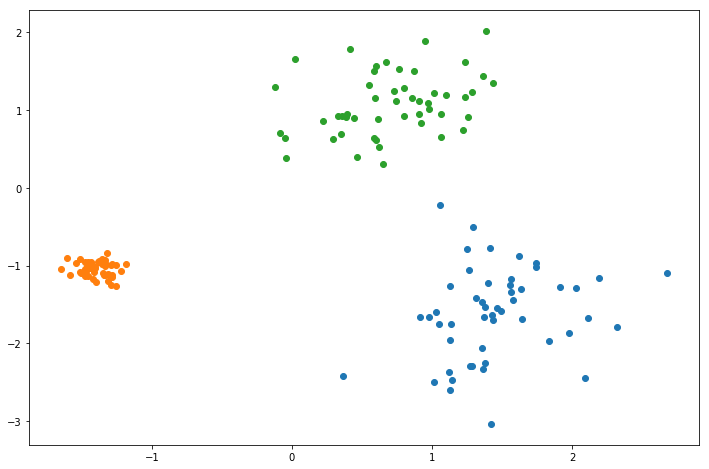

In [21]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(data[0, :, 0], data[0, :, 1])
ax.scatter(data[1, :, 0], data[1, :, 1])
ax.scatter(data[2, :, 0], data[2, :, 1])

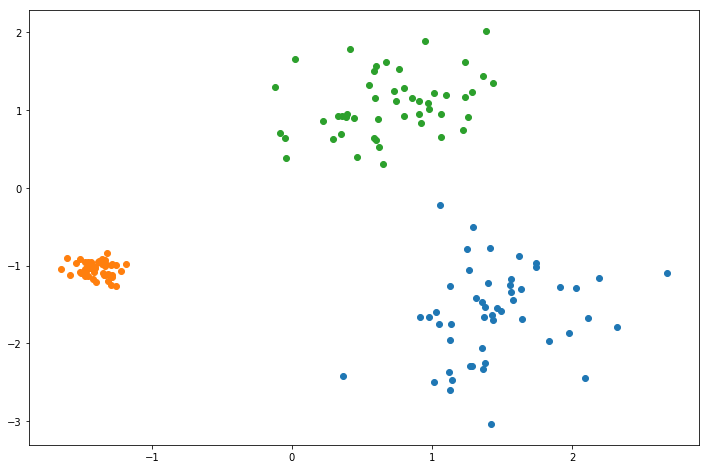

In [22]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
X = data.reshape((K*N, D))
ax.scatter(X[:50, 0], X[:50, 1])
ax.scatter(X[51:100, 0], X[51:100, 1])
ax.scatter(X[101:, 0], X[101:, 1])

In [23]:
X = data.reshape((K*N, D))

In [24]:
def logsumexp(x, axis=0):
    # x with size K x N
    max_val = np.max(ll)
    y = x - max_val
    ll_sum = max_val + np.log(np.sum(np.exp(y), axis=axis, keepdims=True))
    inf_index = np.isinf(ll_sum)
    if np.any(inf_index):
        ll_sum[inf_index] = max_val[inf_index]
    return ll_sum

def Expectation(X, mu, Sigma):
    # X: N x D
    # mu: K x D
    # Sigma: K x D x D
    # return E: K x N
    K = mu.shape[0]
    N = X.shape[0]
    ll = np.zeros((K, N))
    for k in range(K):
        ll[k, :] = loggausspdf(X, mu[k, :], Sigma[k, :, :])
    ll_sum = logsumexp(ll, axis=0)   
    E = np.exp(ll - ll_sum)
    
    return E, np.sum(ll_sum)

def Maximization(X, E):
    # X: N x D
    # E: K x N
    # return: mu: K x D
    #         Sigma: K x D x D
    K = E.shape[0]
    mu_hat = np.zeros((K, D))
    Sigma_hat = np.zeros((K, D, D))
    for k in range(K):
        e = E[None, k, :]
        mu_hat[k, :] = e@X/np.sum(e)
        temp = np.sqrt(e).T*(X - mu_hat[k, :])
        Sigma_hat[k, :, :] = temp.T@temp/np.sum(e)
        
    return mu_hat, Sigma_hat

In [25]:
N = X.shape[0]

J = np.arange(N)
V = np.ones(N)

cluster_assign = np.random.choice(K, N)
# cluster_assign = np.zeros(N)
# cluster_assign[:50] = 0
# cluster_assign[51:100] = 1
# cluster_assign[101:] = 2
E = scipy.sparse.coo_matrix((V,(cluster_assign,J)),shape=(K, N)).toarray()

ll_temp = []
for it in range(100):
    mu_est, Sigma_est = Maximization(X, E)
    E, ll = Expectation(X, mu_est, Sigma_est)
    ll_temp.append(ll)

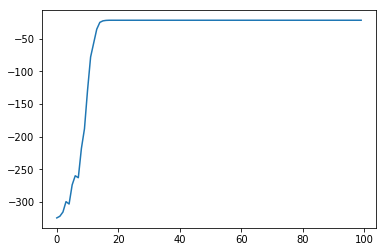

In [26]:
plt.plot(ll_temp)

In [27]:
def GMM(X, K):
    # X: data N x D
    # K: number of clusters
    N = X.shape[0]

    J = np.arange(N)
    V = np.ones(N)

    cluster_assign = np.random.choice(K, N)
    E = scipy.sparse.coo_matrix((V,(cluster_assign,J)),shape=(K, N)).toarray()

    ll_rec = []
    for it in range(40):
        mu_hat, Sigma_hat = Maximization(X, E)
        E, ll = Expectation(X, mu_hat, Sigma_hat)
        ll_rec.append(ll)
        
    return mu_hat, Sigma_hat, ll_rec
    

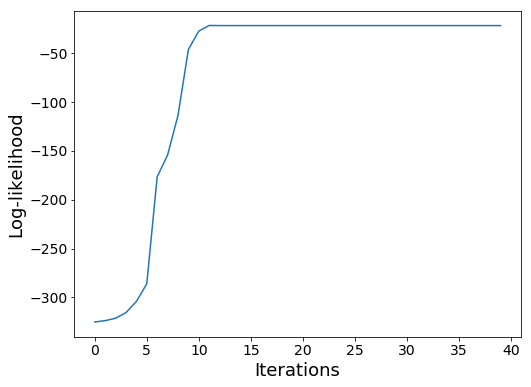

In [28]:
np.random.seed(1234)
mu_hat, Sigma_hat, ll = GMM(X, K=3)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(ll)
ax.set_xlabel("Iterations", fontsize=18)
ax.set_ylabel("Log-likelihood", fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
f.savefig("fig_GMM_ll.png")

In [29]:
Sigma

array([[[0.3 , 0.  ],
        [0.  , 0.3 ]],

       [[0.01, 0.  ],
        [0.  , 0.01]],

       [[0.2 , 0.05],
        [0.05, 0.2 ]]])

In [30]:
# N = X.shape[0]

# J = np.arange(N)
# V = np.ones(N)

# # cluster_assign = np.random.choice(K, N)
# cluster_assign = np.zeros(N)
# cluster_assign[:50] = 0
# cluster_assign[51:100] = 1
# cluster_assign[101:] = 2
# E = scipy.sparse.coo_matrix((V,(cluster_assign,J)),shape=(K, N)).toarray()

# # M-step
# mu_est = np.zeros((K, D))
# Sigma_est = np.zeros((K, D, D))
# for k in range(K):
#     e = E[None, k, :]
#     mu_est[k, :] = e@X/np.sum(e)
#     temp = np.sqrt(e).T*(X - mu_est[k, :])
#     Sigma_est[k, :, :] = temp.T@temp/np.sum(e)
    
# # E-step
# ll = np.zeros((K, N))
# for k in range(K):
#     ll[k, :] = loggausspdf(X, mu_est[k, :], Sigma_est[k, :, :])
# ll_sum = logsumexp(ll, axis=0)   
# E = np.exp(ll - ll_sum)

In [31]:
mu

array([[ 1.48183321, -1.57193389],
       [-1.41263341, -1.05149708],
       [ 0.67096575,  1.0366762 ]])

In [ ]:
mu_est

In [33]:
Sigma

array([[[0.3 , 0.  ],
        [0.  , 0.3 ]],

       [[0.01, 0.  ],
        [0.  , 0.01]],

       [[0.2 , 0.05],
        [0.05, 0.2 ]]])

# Row major, column major

In [34]:
data = np.random.rand(1000,1000)

print("Row means")
%timeit np.mean(data, axis=1)
print("Column means")
%timeit np.mean(data, axis=0)

print("\n\nRow operations")
%timeit data[1, :] + 3
print("Column operations")
%timeit data[:, 1] + 3

Row means
605 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Column means
858 µs ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Row operations
2.27 µs ± 97.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Column operations
8.19 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
data = np.asfortranarray(data)

print("Row means")
%timeit np.mean(data, axis=1)
print("Column means")
%timeit np.mean(data, axis=0)

print("\n\nRow operations")
%timeit data[1, :] + 3
print("Column operations")
%timeit data[:, 1] + 3

Row means
834 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Column means
810 µs ± 227 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Row operations
7.48 µs ± 787 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Column operations
2.26 µs ± 89.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False